In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from src.tables_old import MapTable, df_to_tmp_table, df_to_table, get_machines, get_offers, get_tables, get_tbl_info, table_to_df, get_tbl_timespan
from src.preprocess import preprocess
from src.utils import  time_utc_now, np_min_chunk, df_na_vals, reduce_mem_usage
import seaborn as sns
import matplotlib.pyplot as plt
import logging

import warnings

# Filter out all warnings related to pandas
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
from src.manager import DbManager

# dbm = DbManager('../data/vast.db')
dbm = DbManager('../vast.db')

dbm.connect()
ts = dbm.table_to_df('ts_idx').timestamp
dbm.close()

sec = pd.to_datetime(ts * 1e9).diff().dt.seconds
sec.describe()

# sec

count    138200.000000
mean         60.108010
std         287.022051
min           1.000000
25%          54.000000
50%          56.000000
75%          59.000000
max       84261.000000
Name: timestamp, dtype: float64

Mode: 54.0


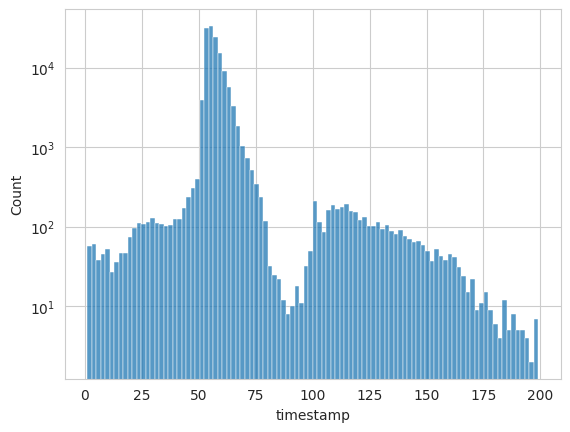

In [87]:
import seaborn as sns
print('Mode:', sec.mode()[0])
sns.histplot(sec[sec < 200], bins=100);
plt.yscale('log');

In [5]:
dbm.close()

In [6]:
import sqlite3
import os
import pandas as pd
from src.manager import DbManager

# db_path = '../data/vast.db'
db_path = '../vast.db'

dbm = DbManager(db_path)
dbm.connect()
timespan = dbm.get_tbl_timespan('ts_idx')
total_days = timespan.total_seconds() / (3600 * 24)

print('Timespan:', timespan)

# dbm.execute('VACUUM')
size = os.path.getsize(db_path) / (1024 * 1024) # Size in Mb

try:
    print(f'Size: {size: .2f} mb')
    print(f'Size per day: {size / total_days: .2f} mb')
    print(f'Size per year: {size / total_days * 365: .0f} mb')
except:
    pass

dbm.close()

Timespan: 168 days 03:28:47
Size:  445.97 mb
Size per day:  2.65 mb
Size per year:  968 mb


In [7]:
dbm.connect()
dbm.get_db_stats()

,name,pages,size,percentage
0,total,114199,446.09,100.00
1,reliability_ts,57245,223.61,50.13
2,avg_snp,19807,77.37,17.34
3,cost_ts,6930,27.07,6.07
4,online_ts,5936,23.19,5.20
5,rent_ts,5818,22.73,5.09
6,avg_ts,5598,21.87,4.90
7,eod_ts,4498,17.57,3.94
8,disk_ts,4153,16.22,3.64
9,hardware_ts,3356,13.11,2.94


In [8]:
dbm.close()

In [11]:
dbm.get_tbl_timespan('ts_idx')

Timedelta('168 days 03:28:47')

In [13]:
df = dbm.table_to_df('ts_idx')

In [80]:
df.diff().query('timestamp < 200').describe()

,timestamp
count,138160.000000
mean,58.615569
std,12.740926
min,1.000000
25%,54.000000
50%,56.000000
75%,59.000000
max,199.000000


In [79]:
df.diff().query('timestamp < 10000').mode()

,timestamp
0,54.0


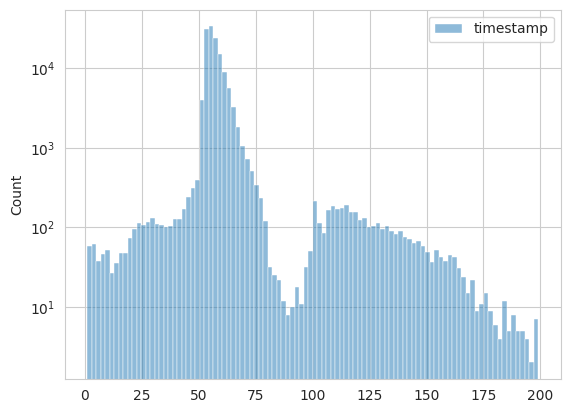

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df.diff().query('timestamp < 200'), bins=100);
plt.yscale('log');

In [82]:
dbm.close()

In [83]:
df.groupby('machine_id')['disk_bw'].resample('1D').mean().round().astype(np.uint16).reset_index().to_sql('disk_bw_avg', conn, if_exists='replace', index=False)

KeyError: 'machine_id'

In [41]:
df.groupby('machine_id')['disk_bw'].resample('1D').std().fillna(0).astype(np.uint16).reset_index().to_sql('disk_bw_std', conn, if_exists='replace', index=False)

4553

In [115]:
conn.close()

In [23]:
import sqlite3
import os
import numpy as np

DB_PATH = '../data'

# Create directories for databases if they don't exist
if not os.path.exists(DB_PATH):
    os.makedirs(DB_PATH)

# Function to create and populate a database with the specified data type and range
def create_and_populate_db(db_name, data_type, value_range, size=100000):
    db_path = os.path.join(DB_PATH, db_name)

    conn = sqlite3.connect(db_path)

    conn.execute(f"CREATE TABLE data (value {data_type})")


    # Generate and insert values within the specified range
    values = None
    if 'INTEGER' in data_type:
        values = np.random.randint(*value_range, size=size, dtype=np.uint32)
    elif 'REAL' in data_type:
        values = np.random.uniform(*value_range, size=size).astype(np.float32)
    else:
        raise ValueError('Unknown type')        
        
    rows = [(value,) for value in values]
    
    
    try:
        # print(rows[:3])
        # conn.executemany("INSERT INTO data (value) VALUES (?)", rows)

        for value in values:
            conn.execute(f"INSERT INTO data (value) VALUES ({value})")

        conn.commit()  
        conn.execute("VACUUM")    
    
    except Exception as e:
        print(e)
    
    conn.close()

# delete exiting db's
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    os.remove(db_path)


# Create and populate the databases
create_and_populate_db('integer_db.sqlite', 'INTEGER', (0, 300))  
# create_and_populate_db('integer_non_null_db.sqlite', 'INTEGER NOT NULL', (0, 1000))
create_and_populate_db('real_db.sqlite', 'REAL', (0, 1))            
# create_and_populate_db('real_non_null_db.sqlite', 'REAL NOT NULL', (0, 1000))            
# Print database sizes
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    db_size = os.path.getsize(db_path) / (1024)  # Size in KB
    print(f"Database '{db_name}' size: {db_size:.2f} KB")

Database 'integer_db.sqlite' size: 932.00 KB
Database 'real_db.sqlite' size: 1564.00 KB


In [48]:
import os
import psutil

In [49]:
# Getting loadover15 minutes
load1, load5, load15 = psutil.getloadavg()

cpu_usage = (load15/os.cpu_count()) * 100

print("The CPU usage is : ", load1)

The CPU usage is :  0.0
